In [38]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat, islice
from cytoolz import partition
from pprint import pprint

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [24]:
from numba import jit
from numpy import pi, exp, ndarray, gradient, concatenate


@jit
def gauss(x: float, sigma: float) -> float:
    return 1 / (2*pi)**0.5 * exp(-(x/sigma)**2/2)


@jit
def ispeak(arr: ndarray) -> ndarray:
    diff = gradient(arr)  # shape: k
    ispos = 0 < diff  # shape: k
    return concatenate([[False], ispos[:-1] & ~ispos[1:]])  # shape: k

In [2]:
def is_available(filename):
    if filename.endswith("_0.h5"):
        return False
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_spectra(filename: str):
    with File(filename, "r") as f:
        try:
            x0 = 500
            x1 = f["/photon_diagnostics/Spectrometer/Wavelength"][...]
            a = (
                f["/photon_diagnostics/Spectrometer/WavelengthSpan"][...]
                * f["/photon_diagnostics/Spectrometer/Pixel2micron"][...]
                / 1000
            )
            arr = f["/photon_diagnostics/Spectrometer/hor_spectrum"][...]
            _, n = arr.shape
            x = a * (np.arange(n) - x0) + x1
            for y in arr:
                yield {"x": x, "y": y}
        except KeyError:
            return

In [3]:
df = pd.read_excel("he_levels.xlsx")
df.head()

,n,config,n*,level (eV),dlevel (eV),level,energy (eV),energy,tau,tau (fs),ref
0,2,1s2p 1P,2.009354,21.218023,NaN,0.779742,-3.369366,-0.123821,50.985152,1.233272,1
1,3,1s3p 1P,3.011143,23.087019,1.868996,0.848426,-1.500370,-0.055137,171.580676,4.150338,1
2,4,1s4p 1P,4.011625,23.742070,0.655052,0.872498,-0.845319,-0.031065,405.728343,9.814099,1
3,5,1s5p 1P,5.011826,24.045801,0.303730,0.883660,-0.541588,-0.019903,791.155985,19.137148,1
4,6,1s6p 1P,6.011929,24.211003,0.165202,0.889731,-0.376386,-0.013832,1365.575765,33.031698,1


In [39]:
runs = [378]
globbed = chain.from_iterable(iglob(f"/data/*/Run_{r:03d}/rawdata/*.h5") for r in runs)
filenames = sorted(fn for fn in set(globbed))
pprint(filenames)
# it = chain.from_iterable(
#     read_spectra(fn)
#     for fn in chain.from_iterable(repeat(filenames))
# )
it = chain.from_iterable(
    read_spectra(fn)
    for fn in filenames
)

['/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493014942.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015042.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015142.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015242.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015342.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015442.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015542.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015642.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015742.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015842.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493015942.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493016042.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493016142.h5',
 '/data/OverseededDoublePulse/Run_378/rawdata/Run_378_493016242.h5',
 '/data/OverseededDoublePulse/Run_

24.265,   1844
24.268,   2000
24.273,   3379
24.276,   2665
24.283,   2265
24.287,   2303
24.289,   2723
24.296,   3536
24.300,   5739
24.304,   4867
24.312,   5969
24.315,   5359
24.321,   5315
24.327,   6271
24.330,   5186
24.333,   6071
24.339,   6412
24.346,   5304
24.350,   6912
24.353,   7007
24.357,   7760
24.364,   5556
24.370,   8546
24.377,   9448
24.383,   8954
24.387,   8496
24.391,   8962
24.395,   7609
24.404,   8633
24.407,   8015
24.413,   7689
24.421,  10925
24.429,  17331
24.433,  17522
24.463,  74455
24.490, 117305
24.515,  23655
24.522,  16930
24.531,  10604
24.538,   7905
24.542,   7199
24.547,   8735
24.550,   9081
24.554,   9419
24.558,  10238
24.568,   9147
24.571,   8261
24.576,   7636
24.578,   8238
24.583,   7727
24.585,   8122
24.592,   5600
24.596,   6597
24.598,   7196
24.605,   5619
24.607,   6498
24.613,   7501
24.618,   7857
24.623,   9284
24.629,   7919
24.633,   8361
24.638,   8235
24.642,   7781
24.644,   8412
24.650,   9410
24.653,   8630
24.660,   

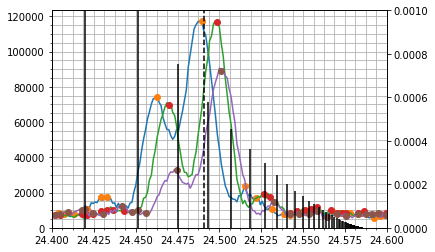

In [49]:
offset = 0
npart = 1
nview = 3
setval = 24.491


def sumup(arr):
    return {
        'x': arr[0]['x'],
        'y': sum(i['y'] for i in arr) / len(arr),
    }


for d in islice(
    (sumup(arr) for arr in partition(npart, it)),
    nview,
):
    x = 1239.84193 / d["x"] - offset
    y = d["y"]
    plt.plot(x, y)
    where = ispeak(y)
    plt.plot(x[where], y[where], "o")
    for xx, yy in zip(x[where], y[where]):
        print("{:6.3f}, {:6.0f}".format(xx, yy))
    print("")
plt.ylim(0, None)
plt.minorticks_on()
plt.grid(True, which='both')
plt.axvline(setval , linestyle='--', color='k')

plt.twinx()
plt.vlines(df["level (eV)"], 0, 1/df["n"]**3)
plt.xlim(24.4, 24.6)
plt.ylim(0, 0.001)
plt.show()